In [1]:
from backtests import fetch_portfolio_states, start_backtest, wait_for_backtest, BacktestRequest
import matplotlib.pyplot as plt

In [2]:
def plot_portfolio_value(assets_states):
    portfolio_values = [state.assets.equityValue for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

In [3]:
def plot_num_of_positions(assets_states):
    portfolio_values = [len(state.assets.positions) for state in assets_states]
    dates = [state.createdAt for state in assets_states]
    
    plt.figure(figsize=(15, 6))
    plt.plot(dates, portfolio_values)
    plt.xlabel('Date')
    plt.ylabel('Positions')
    plt.show()

In [10]:
request = BacktestRequest(
    strategy="Basic strategy",
    symbols=500,
    skip=0,
    use_predictor=False,
    avg_prediction_error=0.025
)

backtest_id = start_backtest(request)

In [ ]:
wait_for_backtest(backtest_id)

In [13]:
portfolio_states = fetch_portfolio_states(backtest_id)

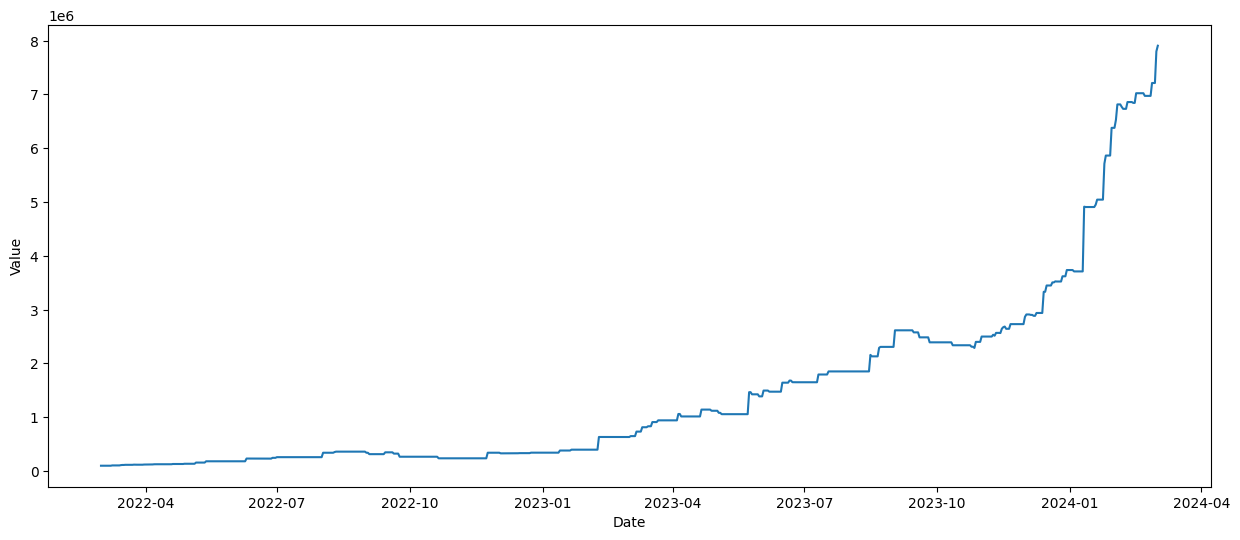

In [14]:
plot_portfolio_value(portfolio_states)

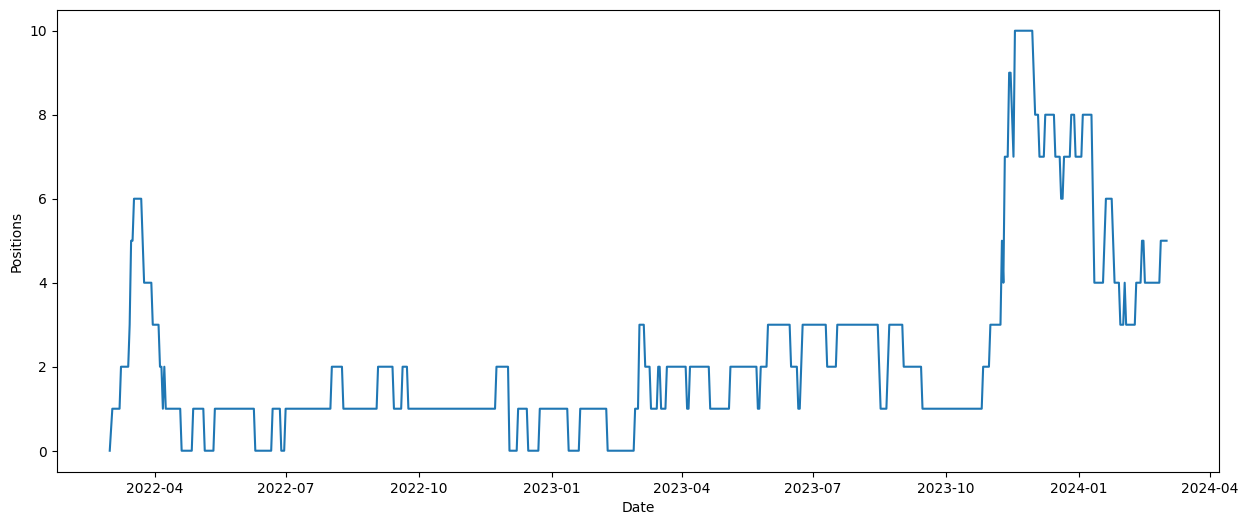

In [15]:
plot_num_of_positions(portfolio_states)

In [20]:
class Investment:
    def __init__(self, symbol, start, end, entry, exit_value):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.entry = entry
        self.exit_value = exit_value
        
    @staticmethod
    def from_position(position, start, end):
        return Investment(position.symbol, start, end, position.averageEntryPrice * position.quantity, position.marketValue)

def get_investments(assets_states):    
    def get_last_positions(assets_states):
        result = []
        for before, after in zip(assets_states[:-1], assets_states[1:]):
            today = before.createdAt.date()
            for position in before.assets.positions:
                
                if position.symbol in [p.symbol for p in after.assets.positions]:
                    continue
                    
                result.append((position, today))
                
        for position in assets_states[-1].assets.positions:
            result.append((position, assets_states[-1].createdAt.date()))
                
        return result

    def get_open_dates(assets_states):
        result = dict()
        for before, after in zip(assets_states[:-1], assets_states[1:]):
            today = before.createdAt.date()
            for position in after.assets.positions:

                if position.symbol in [p.symbol for p in before.assets.positions]:
                    continue

                if position.symbol not in result:
                    result[position.symbol] = []

                result[position.symbol].append(today)

        return result
        
    open_dates = get_open_dates(assets_states)
    last_positions = get_last_positions(assets_states)
    
    return list(sorted([
        Investment.from_position(last, [v for v in open_dates[last.symbol] if v < end][-1], end) for last, end in last_positions
    ], key=lambda i: i.exit_value / i.entry, reverse=True))

In [24]:
investments = get_investments(portfolio_states)

In [25]:
for inv in investments:
    print(f"{inv.symbol}: {inv.exit_value / inv.entry} ({inv.start} to {inv.end})")

ATRA: 2.5953488372093023 (2023-11-12 to 2023-11-29)
ARQT: 2.107936507936508 (2024-01-18 to 2024-02-01)
ARQT: 2.0597014925373136 (2023-12-12 to 2024-01-10)
ARQT: 1.8191653786707882 (2024-02-12 to 2024-03-01)
ANGI: 1.7590361445783134 (2023-11-07 to 2024-03-01)
AMR: 1.714196900395222 (2023-11-09 to 2024-03-01)
ACHR: 1.611295681063123 (2022-03-14 to 2022-04-05)
AFRM: 1.539099526066351 (2023-10-30 to 2023-11-15)
ASAN: 1.5058259081562715 (2023-03-01 to 2023-03-16)
BARK: 1.503676470588235 (2022-03-14 to 2022-03-29)
AZUL: 1.5 (2023-03-01 to 2023-03-09)
ASPN: 1.3846971307120084 (2022-06-29 to 2022-12-01)
ALTO: 1.3802083333333335 (2023-11-07 to 2024-01-09)
ARKB: 1.3284272497897391 (2024-02-08 to 2024-03-01)
ACMR: 1.3210493441599 (2023-11-09 to 2024-01-10)
ADMA: 1.2646239554317549 (2023-07-16 to 2023-08-15)
APP: 1.2115793954874416 (2023-06-21 to 2023-08-14)
BB: 1.20554272517321 (2023-08-21 to 2023-09-13)
AMZN: 1.203864255635373 (2023-10-25 to 2023-11-14)
AVGO: 1.1998509017478756 (2023-11-16 to 20